## Paquid Data Test

In [ ]:
import random

import matplotlib.pyplot as plt
import pandas as pd
import torch

import jmstate
from jmstate import MultiStateJointModel
from jmstate.typedefs import *
from jmstate.utils import *

In [ ]:
paquid = pd.read_csv("data/paquid.csv")  # type: ignore

In [ ]:
def get_trajectory(id: int):
    s = (
        paquid.loc[paquid["ID"].eq(id)]  # type: ignore
        .groupby("HIER")["age"]
        .min()
        .reindex(range(4))
        .dropna()
    )
    s = s[s >= s.cummax()]
    return [(float(a), int(k)) for k, a in s.items()]  # type: ignore


def get_last_visit_age(id: int):
    return paquid[paquid["ID"] == id]["age"].max()


def get_t(id: int):
    return torch.tensor(paquid[paquid["ID"] == id]["age"].values)


def get_X(id: int):
    return torch.tensor(
        paquid.loc[paquid["ID"] == id, ["CEP", "male"]].iloc[0].to_numpy()
    )


def get_Y(id: int):
    return torch.tensor(paquid[paquid["ID"] == id]["MMSE"].values)

In [ ]:
def prepare_all(ids: list[int]):
    trajectories0 = [get_trajectory(i) for i in ids]
    c0 = torch.tensor([get_last_visit_age(i) for i in ids]).view(-1, 1)
    t0 = torch.nn.utils.rnn.pad_sequence(
        [get_t(i) for i in ids], batch_first=True, padding_value=torch.nan
    )
    y0 = torch.nn.utils.rnn.pad_sequence(
        [get_Y(i) for i in ids], batch_first=True, padding_value=torch.nan
    )[..., None]
    x = torch.cat([get_X(i).view(1, -1) for i in ids], dim=0)

    t_min, t_max = torch.nanquantile(t0, 0).item(), torch.nanquantile(t0, 1).item()
    y_min, y_max = torch.nanquantile(y0, 0).item(), torch.nanquantile(y0, 1).item()

    def normalize_t(t: torch.Tensor | float):
        return (2.0 * t - (t_max + t_min)) / (t_max - t_min)

    def normalize_y(y: torch.Tensor):
        return (2.0 * y - (y_max + y_min)) / (y_max - y_min)

    y = normalize_y(y0)
    trajectories = [[(normalize_t(m), s) for (m, s) in traj] for traj in trajectories0]
    t = normalize_t(t0)
    c = normalize_t(c0)

    return x, t, y, trajectories, c

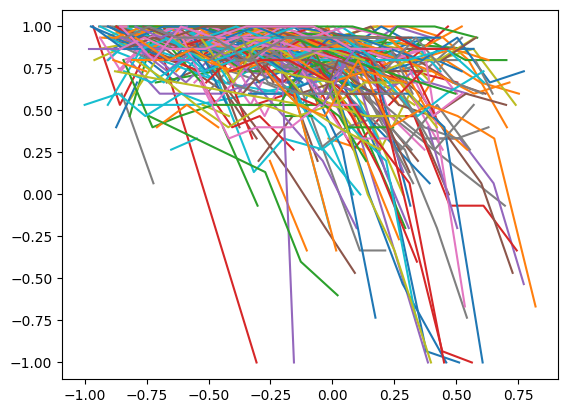

In [5]:
ids = random.sample(range(1, 501), 300)

x, t, y, trajectories, c = prepare_all(ids)

plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [6]:
buckets = build_buckets(trajectories)

In [ ]:
@torch.jit.script
def reg(t, psi):
    a, b, c = psi.chunk(3, dim=-1)
    return (a * torch.tanh(2 * (t - c) / (a * b)) + (1 - a)).unsqueeze(-1)


@torch.jit.script
def f(gamma, x, b):
    psi = gamma + b
    psi[..., 0] = torch.sigmoid(psi[..., 0])
    psi[..., 1] = -psi[..., 1].exp()
    return psi


surv = {key: HazardFns(jmstate.functions.Exponential(1.0), reg) for key in buckets}

init_alphas = {key: torch.zeros(1) for key in buckets}
init_betas = {key: torch.zeros(2) for key in buckets}

init_params = ModelParams(
    torch.zeros(3),
    repr_from_cov(torch.eye(3), method="full"),
    repr_from_cov(torch.eye(1), method="ball"),
    init_alphas,
    init_betas,
    extra=[p for val in surv.values() for p in val[0].parameters()],
)

model_design = ModelDesign(
    f,
    reg,
    surv,
)

In [8]:
data = ModelData(x, t, y, trajectories, c)

Running joint model: 100%|██████████| 200/200 [00:10<00:00, 18.94it/s]


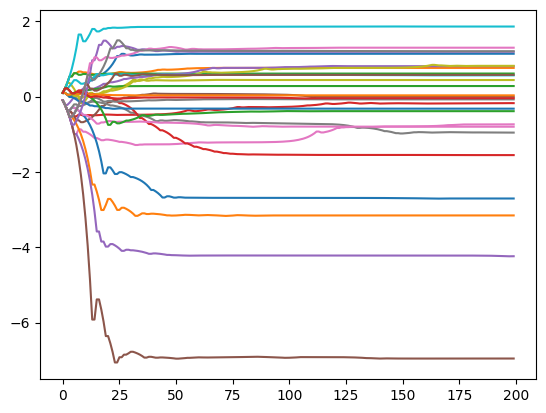

In [9]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    job_factories=[
        jmstate.jobs.RandomFit(torch.optim.Rprop, lr=0.1),
        jmstate.jobs.LogParamsHistory(),
    ],
    max_iterations=200,
    n_steps=10,
)

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [10]:
print(model.params_)
model.params_.get_cov("Q")

ModelParams(gamma=tensor([1.1394, 0.7632, 0.6139]), Q_repr=MatRepr(flat=tensor([-1.7256e-01,  8.0976e-01, -4.1611e-04, -7.3444e-01, -9.5482e-01,
         8.1807e-01]), dim=3, method='full'), R_repr=MatRepr(flat=tensor([1.8621]), dim=1, method='ball'), alphas={(0, 2): tensor([-2.7048]), (2, 3): tensor([-3.1543]), (0, 1): tensor([0.2819]), (1, 2): tensor([-1.5523]), (1, 3): tensor([-4.2378]), (0, 3): tensor([-6.9542])}, betas={(0, 2): tensor([-0.7982, -0.0725]), (2, 3): tensor([0.4413, 0.5655]), (0, 1): tensor([-0.3191,  0.0345]), (1, 2): tensor([-0.3855, -0.0408]), (1, 3): tensor([1.1921, 0.5779]), (0, 3): tensor([1.2998, 1.2061])})


tensor([[ 2.3393, -0.9717, -0.0090],
        [-0.9717,  1.1785,  0.1860],
        [-0.0090,  0.1860,  0.1947]])

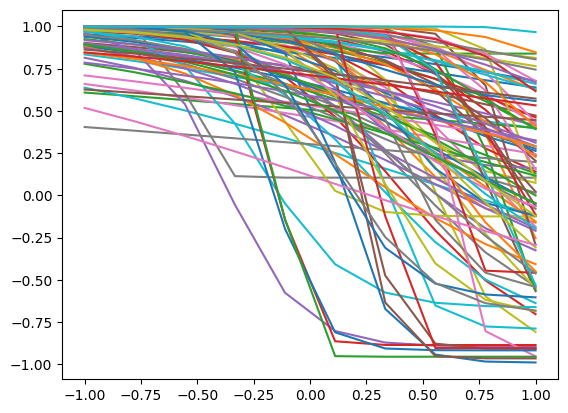

In [ ]:
n_test = 100
t_test = torch.linspace(-1, 1, 10)

Q_dist = torch.distributions.MultivariateNormal(
    torch.zeros(3), model.params_.get_cov("Q")
)
R_dist = torch.distributions.MultivariateNormal(
    torch.zeros(1), model.params_.get_cov("R")
)

x_test = x[:n_test]
b_test = Q_dist.sample((n_test,))
psi_test = model_design.individual_effects_fn(model.params_.gamma, x_test, b_test)
trajectories_init_test = [[trajectories[i][0]] for i in range(n_test)]
y_test = model_design.regression_fn(t_test, psi_test)
y_test += 0 * R_dist.sample(y_test.shape[:-1])
plt.plot(t_test, y_test[:, :, 0].T)
plt.show()

In [12]:
sample_data_test = SampleData(x_test, trajectories_init_test, psi_test)
trajectories_test = model.sample_trajectories(
    sample_data_test, torch.full((len(trajectories_init_test), 1), 1.0)
)